In [14]:
import lifelines
import pymc
import pyBMA
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

In [3]:
#Extracting and formatting data

In [8]:
data = lifelines.datasets.load_rossi()

In [4]:
#Playing with the distribution

In [5]:
#Cox model

If we want to look at covariates, we need a new approach.  We'll use Cox proprtional hazards.  More information here.

In [21]:
#Fitting solution
cf = lifelines.CoxPHFitter()
cf.fit(data, 'week', event_col = 'arrest')

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

Survival is the 1 - Cumulative hazard


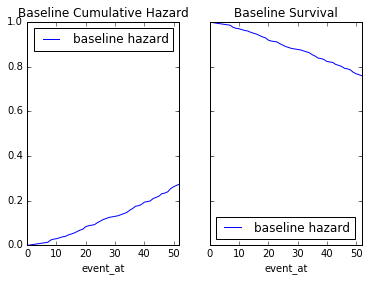

In [25]:
#Solution to 1
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
cf.baseline_cumulative_hazard_.plot(ax = axes[0], title = "Baseline Cumulative Hazard")
cf.baseline_survival_.plot(ax = axes[1], title = "Baseline Survival")
print("Survival is the 1 - Cumulative hazard")

Once we've fit the data, we need to do something useful with it.  Try to do the following things:

1 - Plot the cumulative baseline hazard and survival function
        
        What relation do these have?
        
2 - Predict the functions for a particular set of regressors

3 - Plot the survival function for two different set of regressors

In [17]:
# Solution to prediction
regressors = np.array([[0,0,0,0,0,0,0]])
survival = cf.predict_survival_function(regressors)

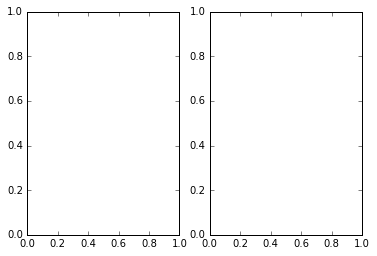

In [20]:
#Solution to plotting multiple regressors
fig, axis = plt.subplots(nrows=1, ncols=2, sharex=True)
regressor1 = np.array([[0,0,0,0,0,0,0]])
regressor2 = np.array([[1,1,1,1,1,1,1]])
survival_1 = cf.predict_survival_function(regressor1)
survival_2 = cf.predict_survival_function(regressor2)
survival_1.plot(ax = axes[0], title = "Baseline Cumulative Hazard")
survival_2.plot(ax = axes[1], title = "Baseline Cumulative Hazard")

In [6]:
#Bayesian cox